# 光学系统建模与光线追踪
## 光学系统建模
光学系统模型用于描述系统构成、系统内部位置与姿态、系统内部各光学部件位置、姿态、形状以及光学特性。
### 模型架构
模型简化为二级架构。包含镜面模型与系统模型。
### 镜面模型
简化的镜面模型为轴对称、二次曲面，无厚度。光学特性简化为对标量波的反射、吸收和投射，以-1到+1之间的实数表示。
- -1表示完全透射，-1至0之间的绝对值表示透过率；
- 0表示完全吸收；
- 1表示完全反射，0到1之间的数值表示反射率。

### 系统模型
简化的系统是以包含全部镜面的列表为核心数据结构的对象。

光学系统模型构建与可视化方法参见下面的示例。

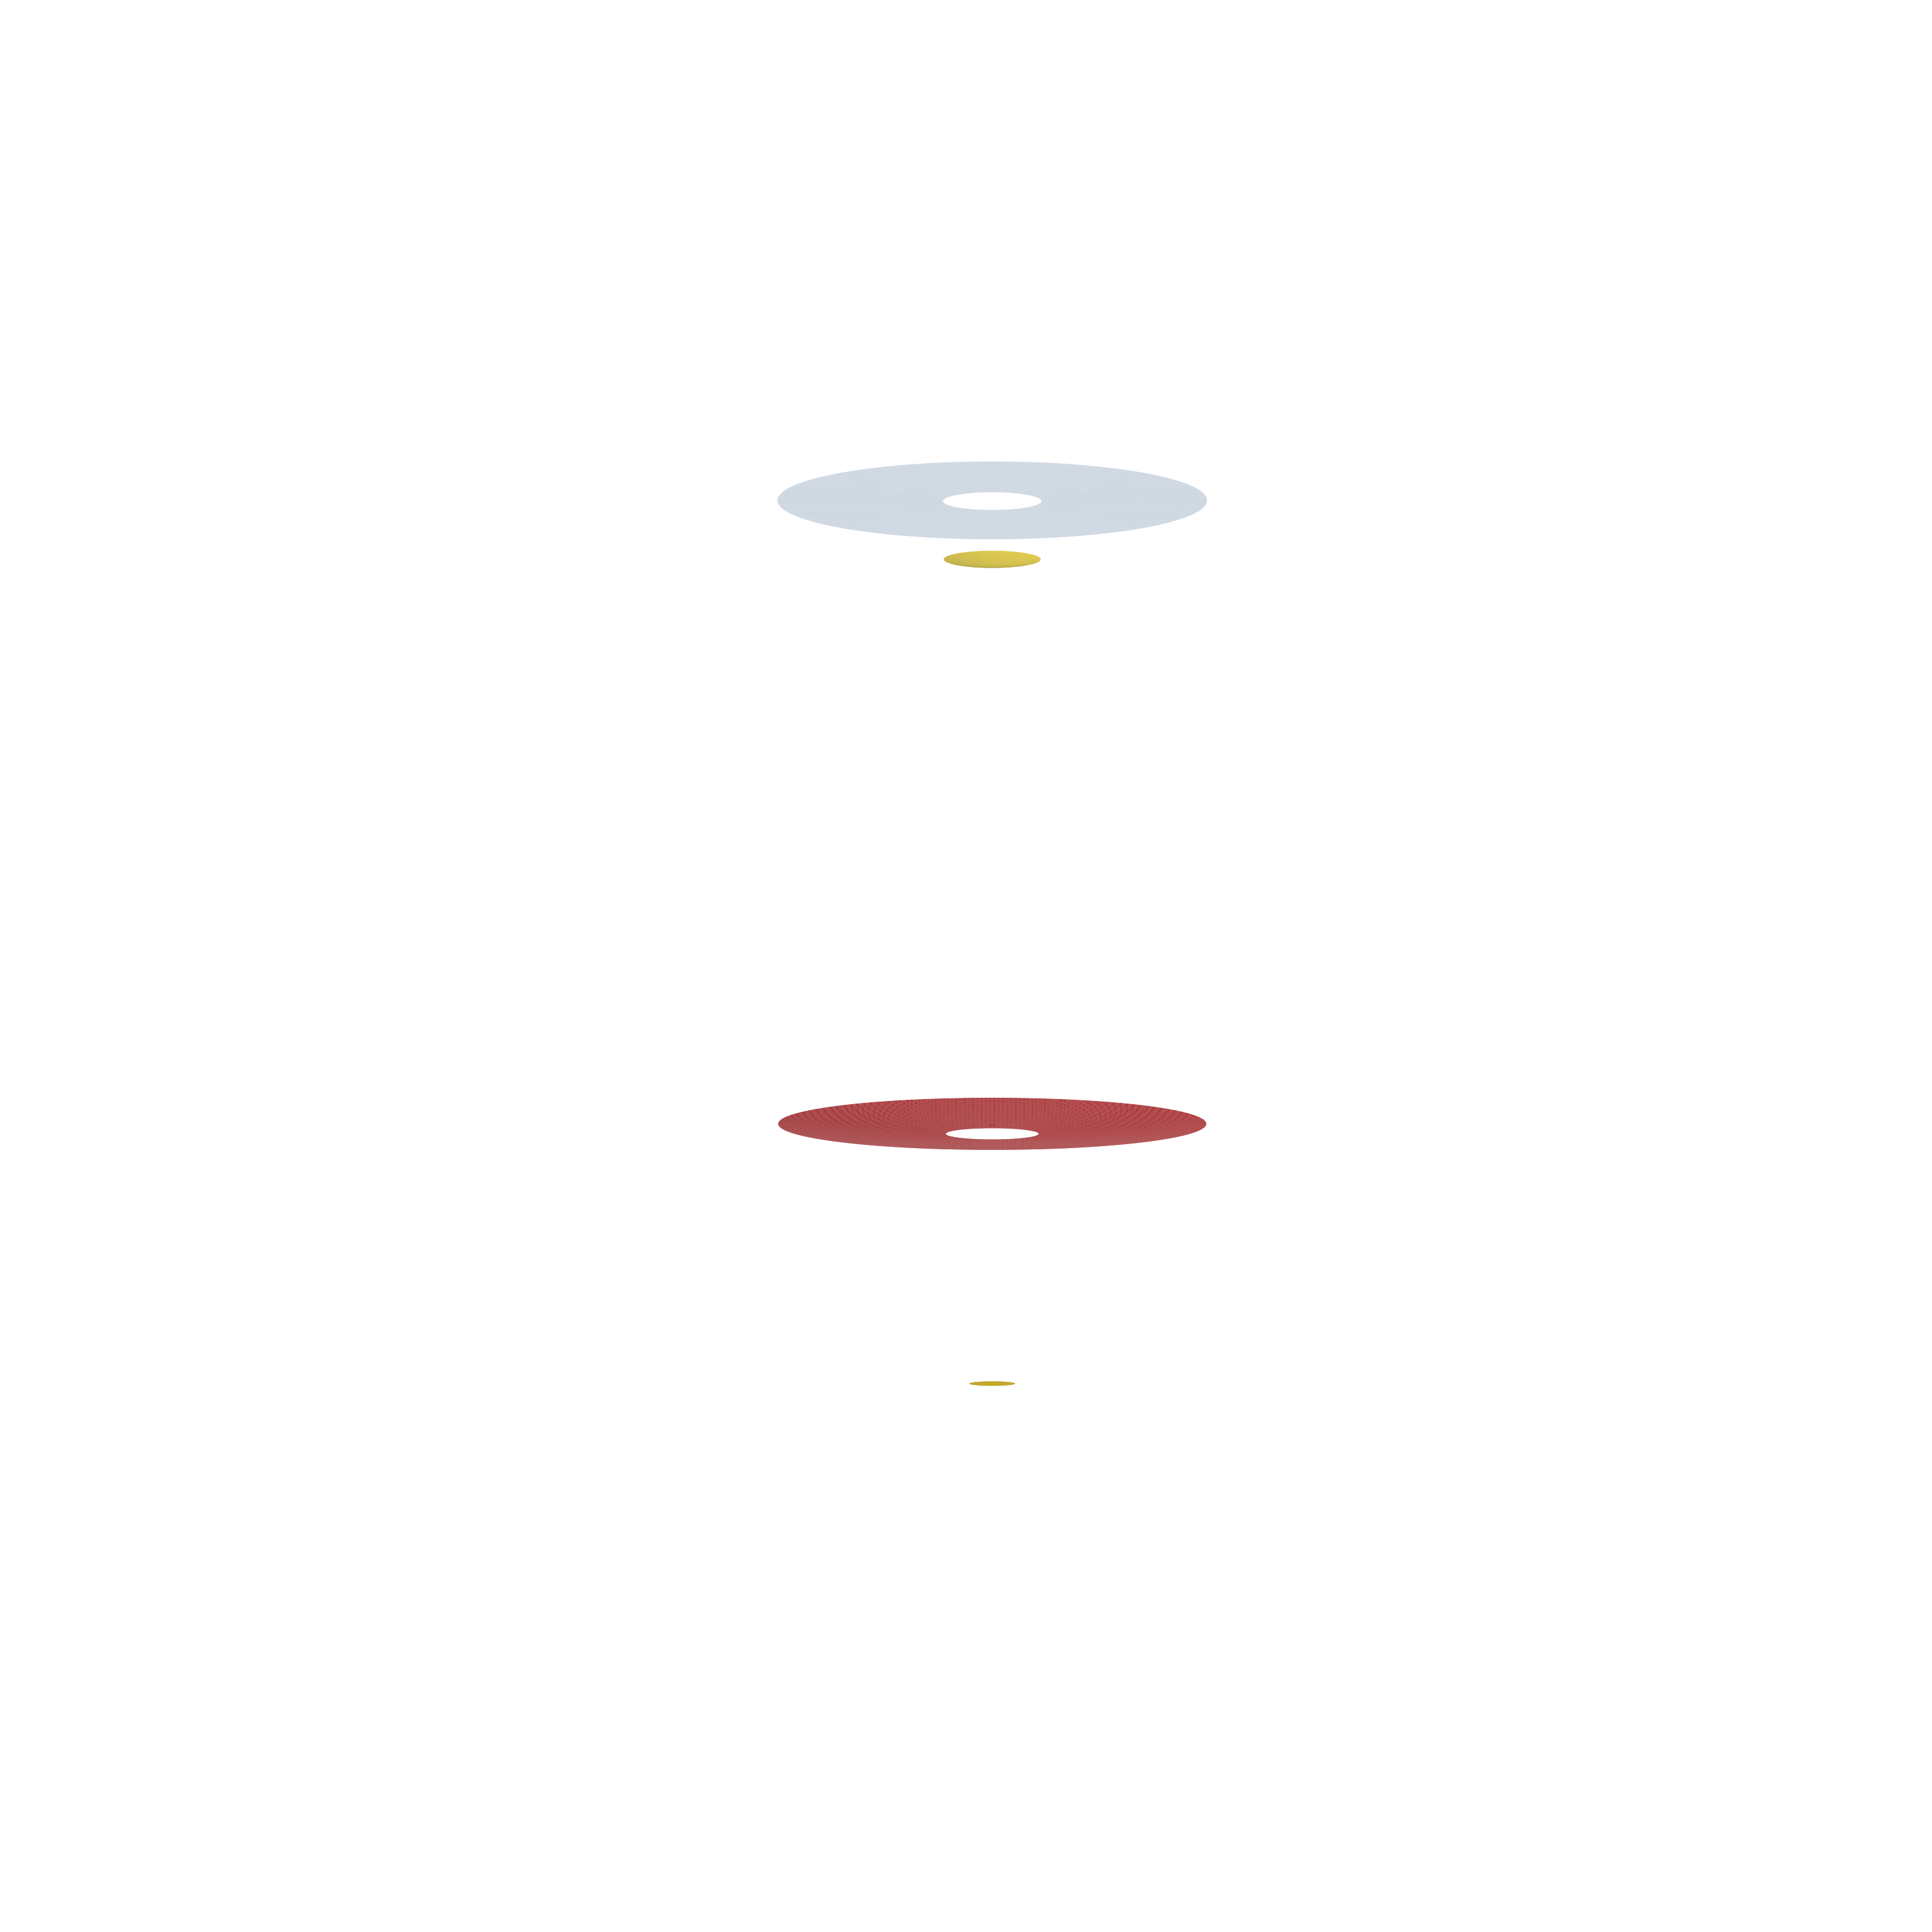

In [816]:
import pimms.optics as op
# 生成简化的卡塞格林反射式望远镜
tel=op.CassegrainReflector()
# 绘制望远镜示意图，图中从上到下，依次是：入口（例如镜头前方保护性玻璃片，虚拟镜面）、次镜（双曲反射镜）、主镜（抛物反射镜）与焦面探测器。
# 绘图函数draw()可选参数包括镜面采样分辨率、视角、图形像素分辨率等，详见代码或docstring。
tris,zs,extent=tel.draw(nside=128, view_angles=(-8,0), figure_size=(3000,3000))

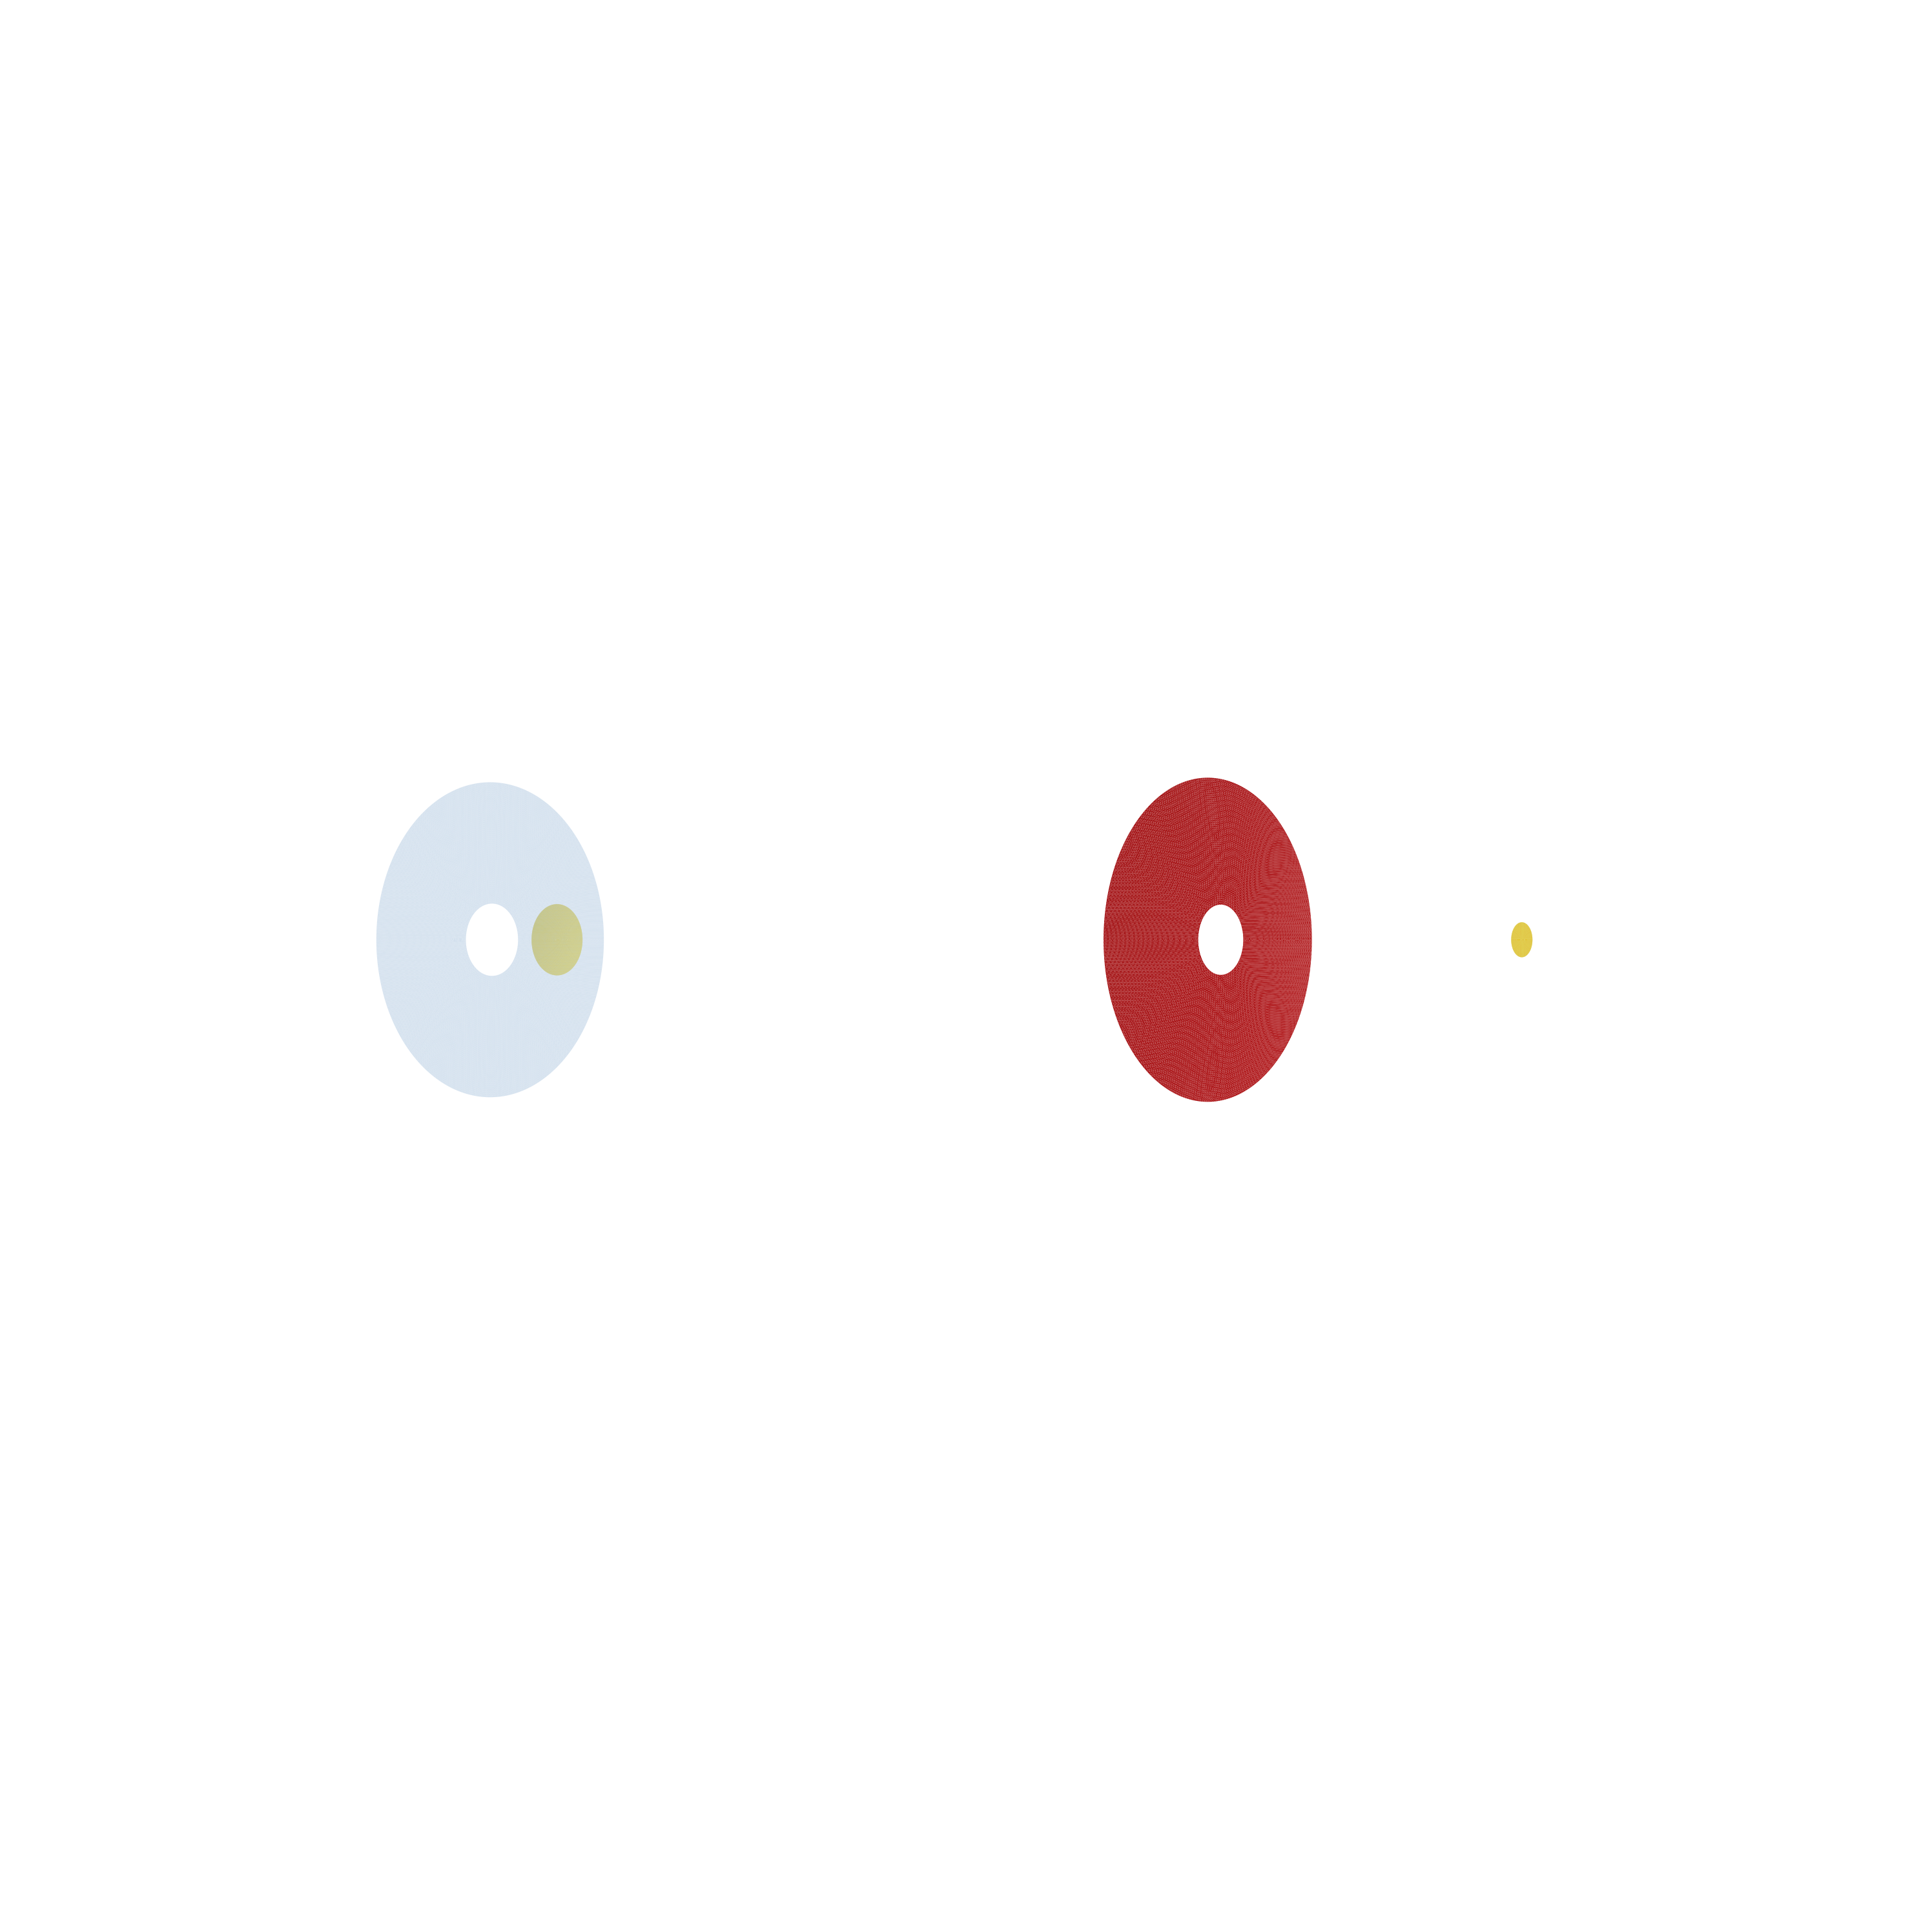

In [817]:
# 对望远镜进行整体旋转（姿态变换）
tel.rotate(op.quat.from_angles(0., np.pi/2.))
# 重新绘制望远镜示意图
tirs,zs,extent=tel.draw(nside=128, view_angles=(0., -60), figure_size=(3000,3000))

## 光源建模
光源属性包括：
- 位置，由球坐标给出，坐标包括方位角（光源在水平面xOy投影与x轴夹角）、天顶角（光源与z轴夹角）、光源到坐标系原点的距离；
- 波长，长度量纲；
- 强度，以光源发出的标量波经过自由空间到达坐标系原点处的积分流强表示，量纲为单位面积的功率。

光源对象在当前软件中的作用是针对给定光学系统的入口，按不同方式，抽样产生“超级光子”。
“超级光子”是当前软件使用的一种数据结构，用于刻画标量波前，构成包括：
- 位置，3维位矢；
- 方向，可理解为电磁波的Poynting矢量方向，3维单位矢量；
- 波长，由产生当前“超级光子”的光源确定；
- 权重，可理解为“超级光子”等效封装的经典光子的数量，单位时间通过单位面积的超级光子加权数量，可表征光子计数率；
- 相位，可理解为标量波在当前位置的相位。

目前已经开发的抽样方法包括：
- 随机抽样，超级光子通过入口的位置随机，不同位置光子流量期望值符合入口光照强度分布；
- 均匀抽样，超级光子通过入口的位置形成均匀格点（其中，如果光源在无穷远处，格点为正交均匀网格；如果光源距离有限，格点为Healpix网格），不同位置光子流量期望值符合入口光照强度分布；
- 抖动抽样，在均匀抽样基础上，增加整体随机抖动，从而抑制均匀网格的空间锯齿效应与频率域伪信号；
- 准星抽样，超级光子按交叉线、同心环位置通过入口，交叉线方位角等间隔，同心环半径非等间距，用于寻找光学系统的光阑。

光源与光学系统联合实验示例如下。

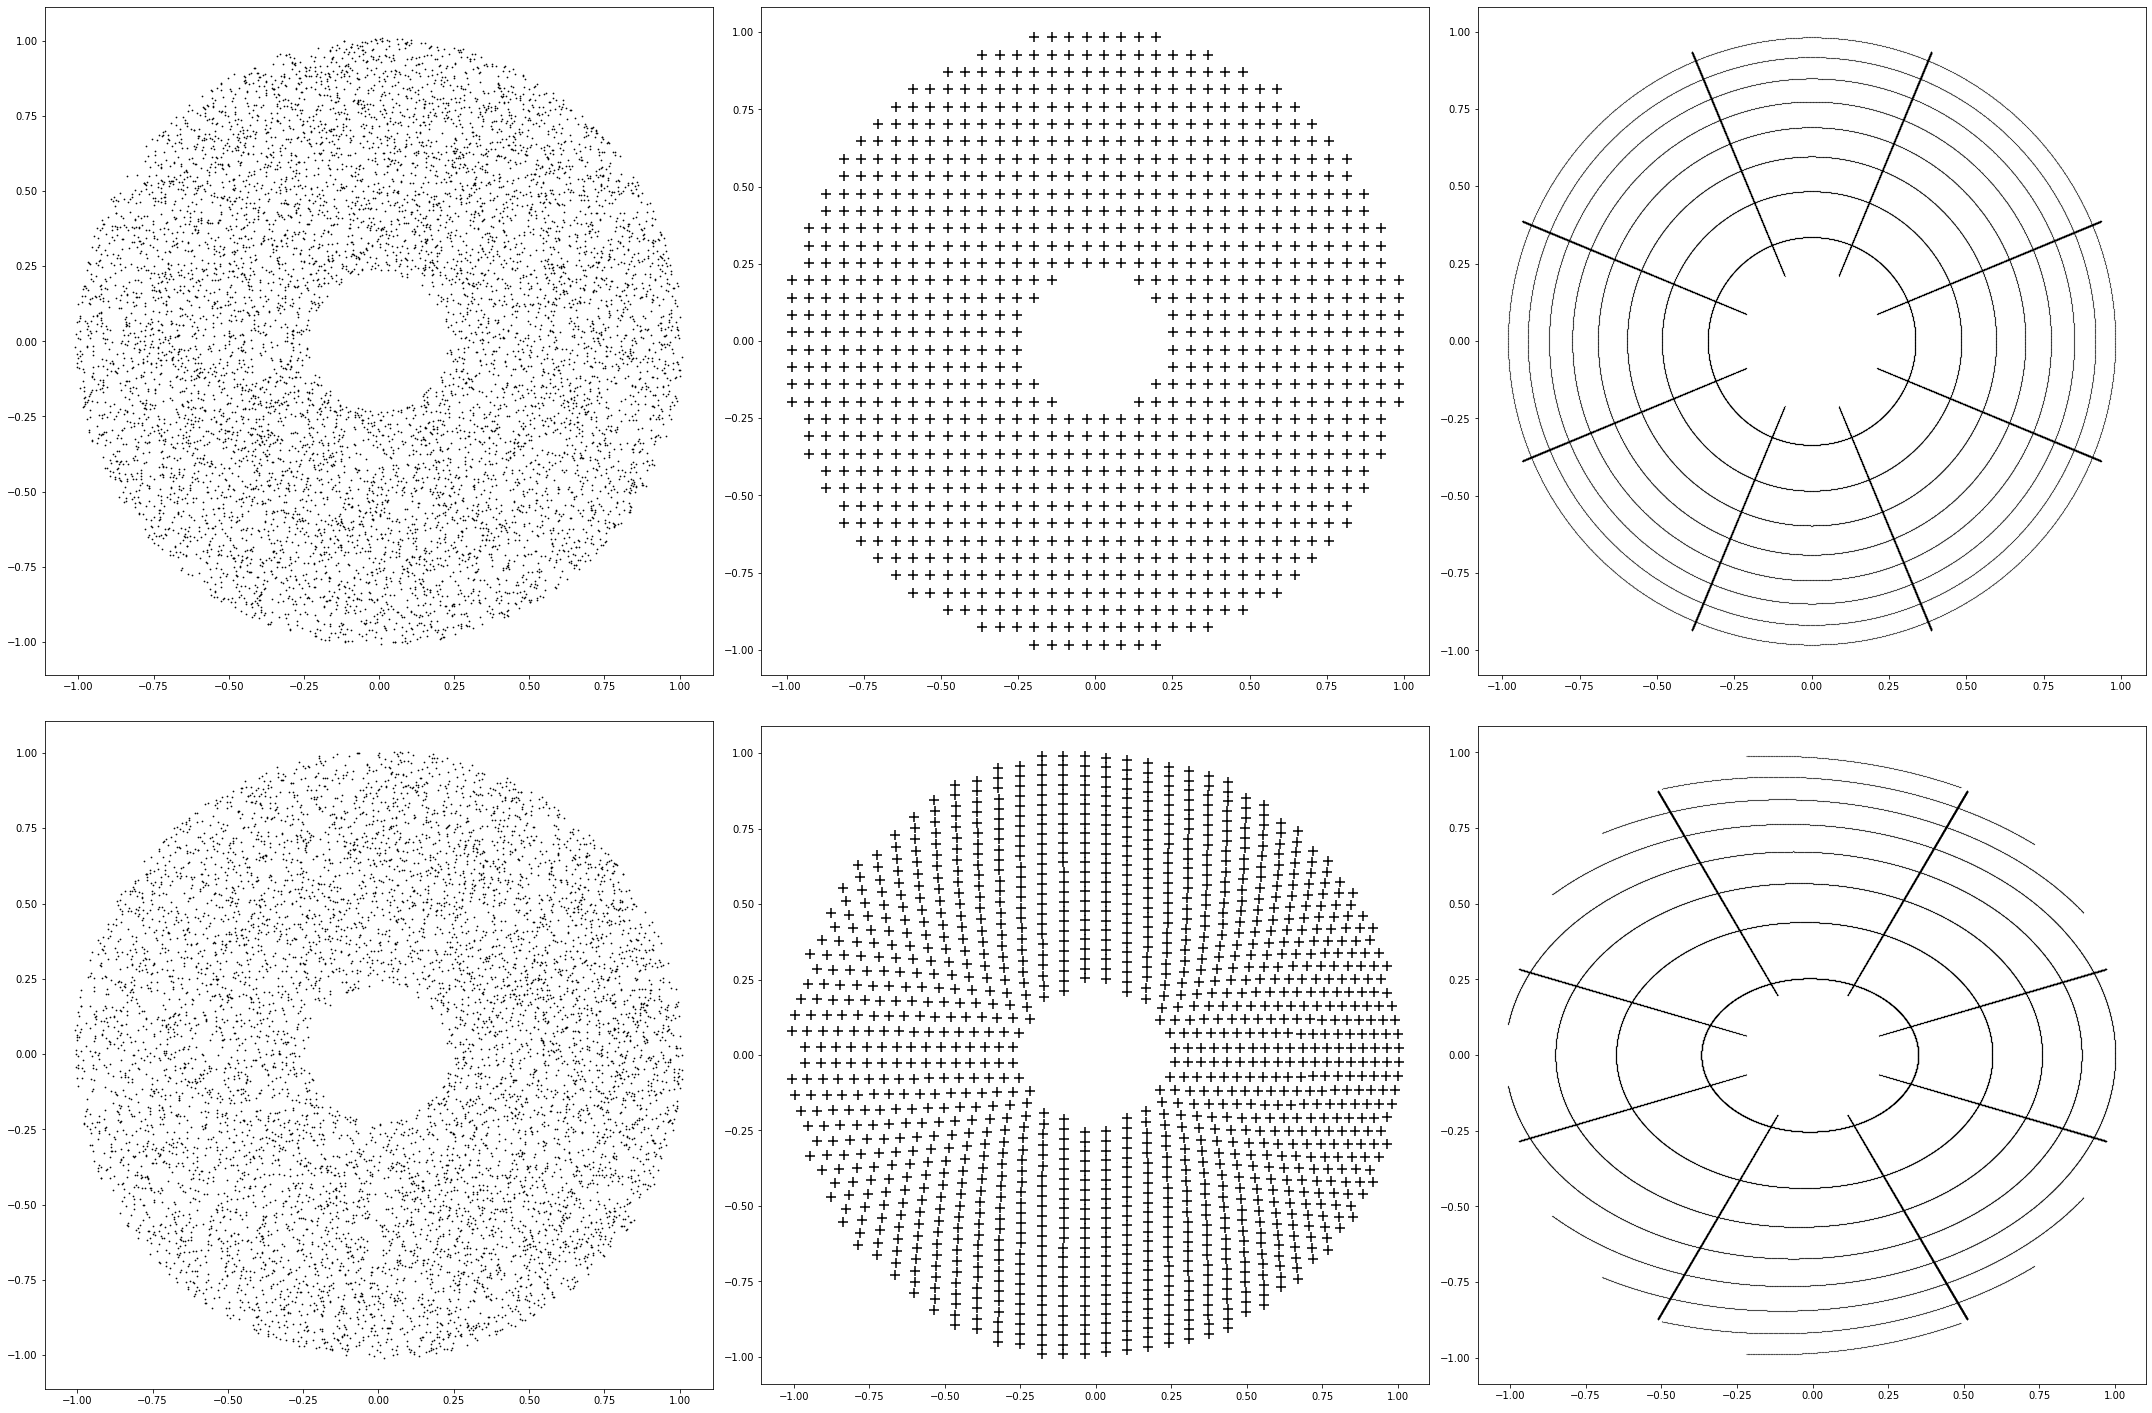

In [872]:
# 创建一个位于天顶、无穷远处的光源
src=op.LightSource((0., 0., np.inf))
# 对光源在望远镜入口处1毫秒内经过的光子进行随机抽样、均匀抽样与准星抽样
tel=op.CassegrainReflector()
p0,q0=src(tel.get_entrance(), 8000, 1e-3, sampling='random')
p1,q1=src(tel.get_entrance(), 1000, 1e-3, sampling='uniform')
p2,q2=src(tel.get_entrance(), 5000, 1e-3, sampling='crosshair')
fig=plt.figure(figsize=(30,20))
ax=fig.add_subplot(231)
ax.scatter(q0['position'][:,0],q0['position'][:,1],  2.,marker='.',color='k')
ax.set_aspect('equal')
ax=fig.add_subplot(232)
ax.scatter(q1['position'][:,0],q1['position'][:,1],100.,marker='+',color='k')
ax.set_aspect('equal')
ax=fig.add_subplot(233)
ax.scatter(q2['position'][:,0],q2['position'][:,1], .05,marker='.',color='k')
ax.set_aspect('equal')
# 创建45度斜入射、近距离的光源
src=op.LightSource((0., np.deg2rad(45), 10))
p0,q0=src(tel.get_entrance(), 11000, 1e-3, sampling='random')
p1,q1=src(tel.get_entrance(),  3000, 1e-3, sampling='uniform')
p2,q2=src(tel.get_entrance(),  7000, 1e-3, sampling='crosshair')
ax=fig.add_subplot(234)
ax.scatter(q0['position'][:,0],q0['position'][:,1],  2.,marker='.',color='k')
ax.set_aspect('equal')
ax=fig.add_subplot(235)
ax.scatter(q1['position'][:,0],q1['position'][:,1],100.,marker='+',color='k')
ax.set_aspect('equal')
ax=fig.add_subplot(236)
ax.scatter(q2['position'][:,0],q2['position'][:,1], .05,marker='.',color='k')
ax.set_aspect('equal')
plt.tight_layout()

## 光线追踪

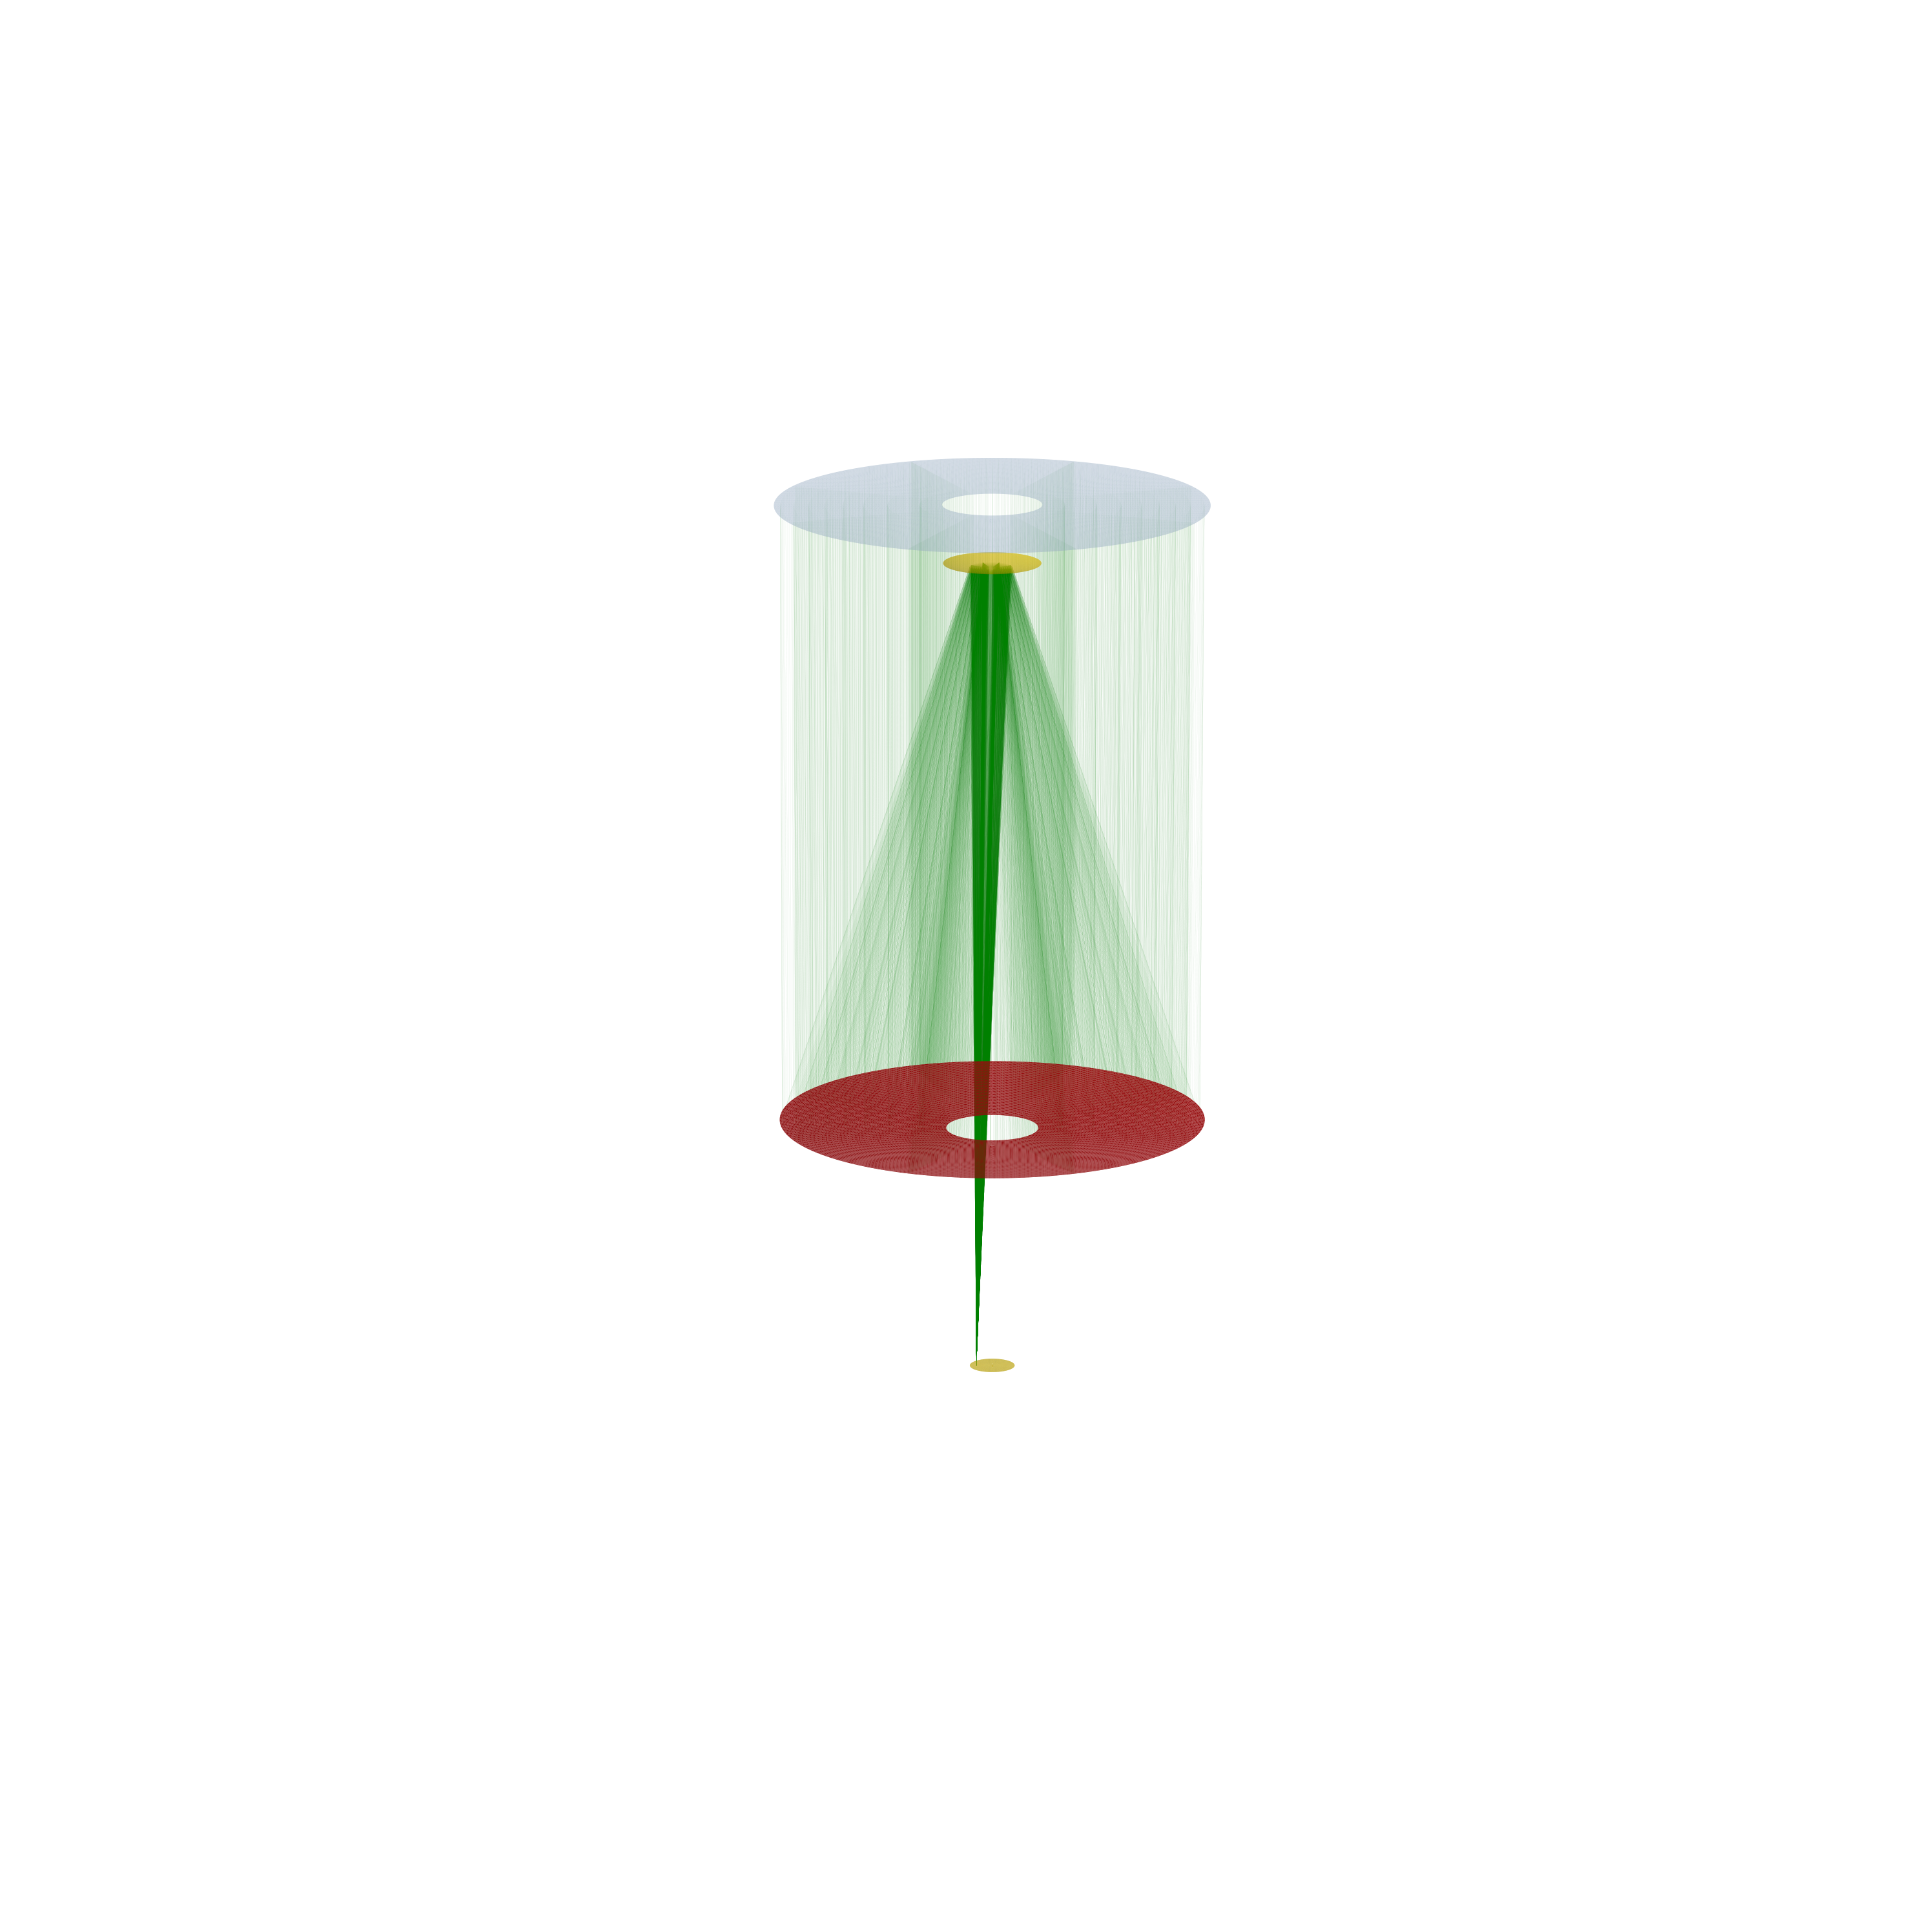

In [890]:
src=op.LightSource((0., np.deg2rad(5./60.), np.inf))
p,q=src(tel.get_entrance(),200,1e-3,sampling='crosshair')
pt,mt=tel.trace(q)
tris,zs,extent=tel.draw(nside=128, raytrace=pt, view_angles=(15,-90), figure_size=(3000,3000))